# Problem Statement

1. We are given a dataset consisting of two csv files train_bodies.csv which contains the set of news articles bodies,while train-stances.csv resembles the articles for each of these bodies being identified using the body id.

2. After training from these samples we need to detect whether the given headline agrees,disagrees,discusses,unrelated with the body id


## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical,plot_model

from keras.models import Input,Model,Sequential
from keras.layers import LSTM,Embedding,Dropout,Activation,Reshape,Dense,GRU,Add,Flatten,concatenate,Bidirectional

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical,plot_model
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint


# Dataset understanding
The train_bodies contain the entries for the body id and associated article Body
The train_stances contain the entries for the headlines associated with the particular body id and its labelled stance
One body present in train_bodies can have multiple associated headlines present in train_stances and it's corresponding stance label
1683 :- Number of article Body present
49972 number of total headlines present for the 1683 different article body

## Dataset Preparation

**train_bodies.csv** contains body id and article body for training  
**train_stances.csv** contains headlines corresponding to body id and associated labelled stance with it


In [4]:
DATASET_PATH = "../input/fake-news-challenge/"

train_bodies = pd.read_csv(os.path.join(DATASET_PATH,'train_bodies.csv'))
# train_bodies.head()
train_stance = pd.read_csv(os.path.join(DATASET_PATH,'train_stances.csv'))

# Combining the CSV

I am preparing a final csv in each row will correspond to a unique entry
i.e each row will correspond to a unique combination of headline,bodyid and article body 

The above is needed for making simplicity in further data preparation steps we need to execute


In [5]:
# # Run commented code to combine the two csv file{train_bodies.csv,train_stances.csv} into data_combined.csv file
# from tqdm.notebook import tqdm
# count=0
# for i in tqdm(range(train_stance.shape[0])):
#     for j in range(train_bodies.shape[0]):
#         if train_bodies.loc[j,'Body ID']==train_stance.loc[i,'Body ID']:
#             train_stance.loc[i,'articleBody'] = train_bodies.loc[j,'articleBody']


# train_stance.to_csv(os.path.join(os.getcwd(),'data_combined.csv'),index=False)

In [6]:
import pandas as pd

# Load the CSV files into pandas DataFrames
# df1 = pd.read_csv('file1.csv')
# df2 = pd.read_csv('file2.csv')

# Merge the DataFrames on the 'bodyid' column
merged_df = pd.merge(train_stance, train_bodies, how = 'left', on='Body ID')
# merged_df = pd.concat([train_bodies.set_index('Body ID'), train_stance.set_index('Body ID')], axis=1, join='inner')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('data_combined.csv', index=False)


In [7]:
data = pd.read_csv(os.path.join(os.getcwd(),'data_combined.csv'))#generated from Fake News stanford.ipynb
data.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [8]:
data['stance_cat'] = data['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
data['Stance'].value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [9]:
class_names = ['agree', 'disagree','discuss', 'unrelated']

In [10]:
# corpus = np.r_[data['Headline'].values,data['articleBody'].values]
# print(49972*2)
# print(len(corpus)) # first 49972 contains the Headline and next 49972 contains the articleBody

# vocabulary = []
# for sentence in corpus:
#     vocabulary.extend(sentence.split(' '))

# vocabulary = list(set(vocabulary))
# vocab_length = len(vocabulary)
# print("Vocabulary Length is {0}".format(vocab_length))


In [11]:
import numpy as np

# Assuming 'data' is your dataset containing 'Headline' and 'articleBody' columns

# Calculate the total length of the corpus
total_length = data.shape[0] * 2

# Initialize an empty set for vocabulary
vocabulary = set()

# Process the corpus in chunks
chunk_size = 1000  # Adjust the chunk size based on your memory capacity
for i in range(0, total_length, chunk_size):
    start_idx = i
    end_idx = min(i + chunk_size, total_length)
    
    # Extract a chunk of headlines and article bodies
    chunk_headlines = data['Headline'].iloc[start_idx // 2: end_idx // 2].values
    chunk_article_bodies = data['articleBody'].iloc[start_idx // 2: end_idx // 2].values
    
    # Concatenate headlines and article bodies into a single chunk
    chunk_corpus = np.r_[chunk_headlines, chunk_article_bodies]
    
    # Update the vocabulary set with words from the current chunk
    for sentence in chunk_corpus:
        vocabulary.update(sentence.split())

# Calculate the length of the vocabulary
vocab_length = len(vocabulary)
print("Vocabulary Length is {0}".format(vocab_length))


Vocabulary Length is 54050


## Model Training Parameters

In [12]:
max_features = 5000
MAX_NB_WORDS = 24000
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH = 64

## Creating Embedding Matrix For Headline and Body

We create Emebdding Matrix for headline and Body to be served as a first layer of Deep learning Model

In [13]:
GLOVE_DIR = "../input/glove50d/"
def setup_embedding_index():
    embedding_index=dict()
    f = open(os.path.join(GLOVE_DIR,"glove.6B.50d.txt"),encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:],dtype='float32')
        embedding_index[word] = coefs
    f.close()
    return embedding_index
embeddings_index = setup_embedding_index()

## Padding headline and body 

We pad the headline into length of 16 as headline is of shorter length and body into length of 48 as observed best performing parameter for body is 48.

In [14]:
tokenizer_headline = Tokenizer(num_words=max_features, split=' ')
tokenizer_headline.fit_on_texts(data.loc[:,'Headline'].values)
vocab_headline_length = len(tokenizer_headline.word_index)+1

encoded_docs_headline = tokenizer_headline.texts_to_sequences(data.loc[:,'Headline'])
padded_docs_headline = pad_sequences(encoded_docs_headline, maxlen=16, padding='post')

print(vocab_headline_length)
word_index_headline = tokenizer_headline.word_index

NUM_WORDS_HEADLINE = vocab_headline_length

3880


In [15]:
tokenizer_body = Tokenizer(num_words=max_features, split=' ')
tokenizer_body.fit_on_texts(data.loc[:,'articleBody'].values)
vocab_body_length = len(tokenizer_body.word_index)+1

encoded_docs_body = tokenizer_body.texts_to_sequences(data.loc[:,'articleBody'])
padded_docs_body = pad_sequences(encoded_docs_body, maxlen=48, padding='post')

print(vocab_body_length)
word_index_body = tokenizer_body.word_index


NUM_WORDS_BODY = vocab_body_length
print(NUM_WORDS_BODY)

27428
27428


In [16]:

embedding_matrix_headline = np.zeros((NUM_WORDS_HEADLINE, EMBEDDING_DIM))

for word, i in tokenizer_headline.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_headline[i] = embedding_vector
dims = len(embedding_matrix_headline[0])

print(dims)

50


In [17]:

embedding_matrix_body = np.zeros((NUM_WORDS_BODY, EMBEDDING_DIM))

for word, i in tokenizer_body.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_body[i] = embedding_vector
dims = len(embedding_matrix_body[0])

print(dims)

50


In [18]:
print(padded_docs_headline.shape)
print(padded_docs_body.shape)

(49972, 16)
(49972, 48)


## Model Architecture

In [19]:
input_headline = Input(shape=16,name='input_headline')
embedding_layer_headline = Embedding(input_dim = vocab_headline_length,output_dim = 50,
                                     weights=[embedding_matrix_headline],
                                     input_length = 16,trainable=True)(input_headline)

# lstm_headline = LSTM(units=16)(embedding_layer_headline)

input_body = Input(shape=48,name='input_body')
embedding_layer_body = Embedding(input_dim = vocab_body_length,output_dim = 50,weights = [embedding_matrix_body],
                                 input_length=48,trainable = True)(input_body)
lstm_body = LSTM(units=48)(embedding_layer_body)

addition_layer = concatenate([embedding_layer_headline,embedding_layer_body],axis=1)

# addition_layer = concatenate([lstm_headline,lstm_body],axis=1)
lstm = LSTM(units=64,)(addition_layer)
drop = Dropout(0.25)(lstm)
# dense = Dense(64,activation='relu')(drop)
# flatten = Flatten()(addition_layer)

output = Dense(4,activation='sigmoid')(drop)

model = Model(inputs=[input_headline,input_body],outputs=output)
# from keras.optimizers import SGD
# sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

# model.compile(loss = "categorical_crossentropy", optimizer = sgd,metrics = ['accuracy'])

model.compile(optimizer = 'adam',loss ='categorical_crossentropy',metrics = ['accuracy'])


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_headline (InputLayer)     [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_body (InputLayer)         [(None, 48)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 16, 50)       194000      input_headline[0][0]             
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 48, 50)       1371400     input_body[0][0]                 
______________________________________________________________________________________________

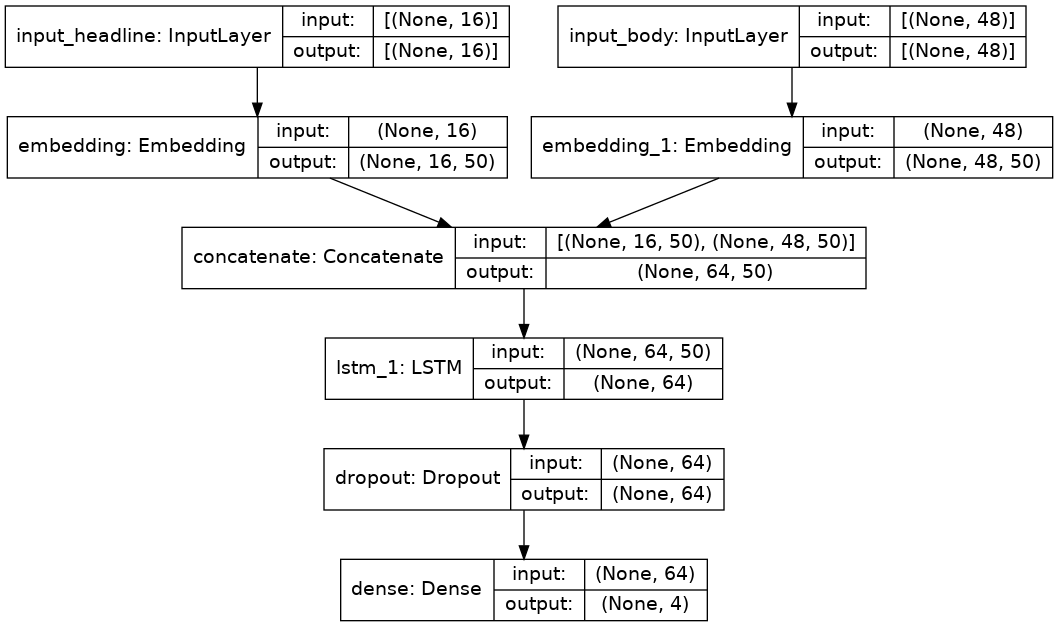

In [21]:
plot_model(model, to_file='model_glove_lstm.png', show_shapes=True, show_layer_names=True)

In [22]:
padded_docs_headline_train = padded_docs_headline[:int(len(padded_docs_headline)*0.9),:]
padded_docs_headline_test = padded_docs_headline[int(len(padded_docs_headline)*0.9):,:]

padded_docs_body_train = padded_docs_body[:int(len(padded_docs_body)*0.9),:]
padded_docs_body_test = padded_docs_body[int(len(padded_docs_body)*0.9):,:]

labels = to_categorical(data.loc[:,'stance_cat'])

labels_train = labels[:int(len(labels)*0.9),:]
labels_test = labels[int(len(labels)*0.9):,:]


In [23]:
print(labels)

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


## Creating Checkpoints 

For saving the latest model trained after every epoch

In [24]:
# MODELS_DIR = os.path.join("/home/abhinav/fake_news_challenge/model/glove_lstm")
filepath = os.path.join(os.getcwd(),"{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Model Training

In [25]:
model_history = model.fit([padded_docs_headline_train,padded_docs_body_train],labels_train,epochs=20,shuffle=True,verbose=1,
                          validation_data=([padded_docs_headline_test,padded_docs_body_test],labels_test),
                                          callbacks=[checkpoint])

Epoch 1/20
1406/1406 [==============================] - 66s 46ms/step - loss: 0.7838 - accuracy: 0.7298 - val_loss: 0.5710 - val_accuracy: 0.7965

Epoch 00001: val_accuracy improved from -inf to 0.79652, saving model to /kaggle/working/01-0.80.hdf5
Epoch 2/20
1406/1406 [==============================] - 63s 45ms/step - loss: 0.5283 - accuracy: 0.8106 - val_loss: 0.4696 - val_accuracy: 0.8261

Epoch 00002: val_accuracy improved from 0.79652 to 0.82613, saving model to /kaggle/working/02-0.83.hdf5
Epoch 3/20
1406/1406 [==============================] - 64s 45ms/step - loss: 0.4154 - accuracy: 0.8494 - val_loss: 0.3981 - val_accuracy: 0.8501

Epoch 00003: val_accuracy improved from 0.82613 to 0.85014, saving model to /kaggle/working/03-0.85.hdf5
Epoch 4/20
1406/1406 [==============================] - 63s 45ms/step - loss: 0.3495 - accuracy: 0.8664 - val_loss: 0.3442 - val_accuracy: 0.8737

Epoch 00004: val_accuracy improved from 0.85014 to 0.87375, saving model to /kaggle/working/04-0.87.

## Model Training History

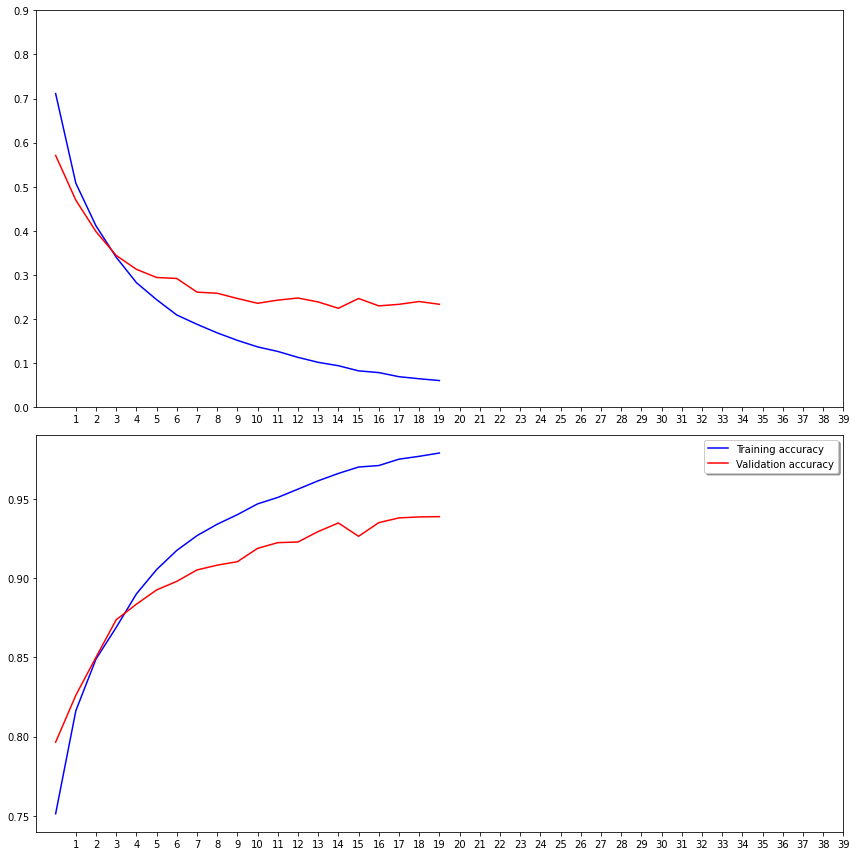

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 40, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 40, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [36]:
 from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have your test data and labels
# test_data: Test data features
# test_labels: True labels for the test data

# Assuming you have your trained GloVe model loaded and ready for inference
# glove_model: Your trained GloVe model

# Step 1: Preprocess test data if necessary

# Step 2: Use the trained model to make predictions on the test data
predicted_probabilities = model.predict([padded_docs_headline_test, padded_docs_body_test])
predicted_labels = np.argmax(predicted_probabilities, axis=1)
print(predicted_labels)
print(type(predicted_labels))
print()
print(labels_test)
print(type(labels_test))
# Step 3: Convert predicted labels to class indices if necessary
#labels_test = np.argmax(labels_test, axis=1)

# Step 4: Generate confusion matrix
conf_matrix = confusion_matrix(labels_test, predicted_labels)

# Step 5: Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


[3 3 3 ... 2 2 3]
<class 'numpy.ndarray'>

[3 3 3 ... 0 2 3]
<class 'numpy.ndarray'>
Confusion Matrix:
[[ 296   14   25   27]
 [  14   50    9    6]
 [  29    3  821   45]
 [  51    6   77 3525]]


In [37]:
data
print()

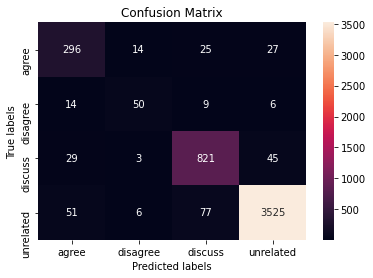

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

In [39]:
from sklearn.metrics import classification_report

print(classification_report(labels_test, predicted_labels))


              precision    recall  f1-score   support

           0       0.76      0.82      0.79       362
           1       0.68      0.63      0.66        79
           2       0.88      0.91      0.90       898
           3       0.98      0.96      0.97      3659

    accuracy                           0.94      4998
   macro avg       0.83      0.83      0.83      4998
weighted avg       0.94      0.94      0.94      4998

